Investigate changes in tags between SkySpark and InfluxDB

In [35]:
import pandas as pd
import influxdb
from datetime import timezone, datetime
import pytz
import matplotlib.pyplot as plt
import certifi

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

print(influxdb.__version__)

client = influxdb.InfluxDBClient(host='206.12.92.81',port=8086, 
                                  username='public', password='public',database='SKYSPARK')


#SELECT last(value), last(time) FROM "SKYSPARK"."autogen"."UBC_EWS" where ("siteRef"='Pharmacy') GROUP BY "groupRef", "equipRef", "navName", "typeRef"


5.2.3


## 1. First let's look at the "metadata" for the Pharmacy building stored in SkySpark   
These are the exported "points" from SkySpark (morning of 2020-06-05)

### Specifically investigating the following in this data:   
#### a. Is the combination of groupRef, equipRef, siteRef, typeRef (BMS name), navName, and unit unique? 
#### b. What does the "mod" field tell us about when metadata was last modified?

***
***



### 1a) Is the combination of groupRef, equipRef, siteRef, typeRef (BMS name), navName, and unit unique? 

No. It is not. There are 185 entries that conflict. i.e. using the above fields, there are 185 sensors that can not be uniquely referenced.
All of these sensors will need to re-queried to tie them to the unique `id` field in the SkySpark database.


In [2]:
#Load export of "metadata" from skyspark for Pharmacy building (performed morning of 2020-06-05)
metadata = pd.read_csv("skyspark-pharmacy-2020-06-05-query.csv")
#Update some tags to remove the @id from them to make them play nice with the data stored in the influxDB
metadata['equipRefclean']=metadata['equipRef'].str.extract('[^ ]* (.*)', expand=True)
metadata['groupRefclean']=metadata['groupRef'].str.extract('[^ ]* (.*)', expand=True)
metadata['siteRefclean']=metadata['siteRef'].str.extract('[^ ]* (.*)', expand=True)
#metadata['connRef']=metadata['connRef'].str.extract('[^ ]* (.*)', expand=True)

#Create a uniqueID by concatenating the equipRef, groupRef, navName, siteRef, bmsName (aka typeRef), and unit
metadata['uniqueId']=metadata['equipRefclean'].fillna('')+' '+metadata['groupRefclean'].fillna('')+' '+metadata['navName'].fillna('')+ \
' '+metadata['siteRefclean'].fillna('')+' '+metadata['bmsName'].fillna('')+metadata['unit'].fillna('')

#Confirm that the unique ID in each data frame is actually unique!
print("There are",len(metadata),"sensors in the Pharmacy building's skyspark metadata")
print(sum(metadata.duplicated(subset=["uniqueId"], keep=False)), "conflicting entries in the dataframe of skyspark data. Saving as 'metad-dups.csv'")
(metadata[:][metadata.duplicated(subset=["uniqueId"], keep=False)]).to_csv("metad-dups.csv")


#Also create a uniqueId without a unit for later checks
metadata['uniqueId_nounit']=metadata['equipRefclean'].fillna('')+' '+metadata['groupRefclean'].fillna('')+' '+metadata['navName'].fillna('')+ \
' '+metadata['siteRefclean'].fillna('')+' '+metadata['bmsName'].fillna('')+metadata['unit'].fillna('')

C:\Users\Alex\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2,54,81,118,133,140,149) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 7938 sensors in the Pharmacy building's skyspark metadata
185 conflicting entries in the dataframe of skyspark data. Saving as 'metad-dups.csv'


### 1b) Counts based on skyspark 'mod' field 

Can we use the `mod` field to determine when sensors were last modifed? Not reliably. Several sensors have some sort of "last value" field updated in the metadata and others may have had various fields updated, but not the ones of concern to us when trying to link the influxDB-housed data back to a unique `id` field in SkySpark. Still, we can see when some changes occured.

In [3]:
mod_df=metadata[["id","mod"]]
mod_df['mod'] = pd.to_datetime(mod_df['mod'].str.split(expand=True)[0]).dt.date
grouped_mod = mod_df.groupby(["mod"]).count()
print(grouped_mod)

              id
mod             
2019-11-01    14
2019-11-07    10
2020-02-26     2
2020-03-07     7
2020-03-19     4
2020-03-25     1
2020-04-08  1132
2020-04-09  5684
2020-04-14    95
2020-04-16     1
2020-04-17    23
2020-04-21     4
2020-04-28     1
2020-04-30   317
2020-05-02   243
2020-05-04     4
2020-05-06     2
2020-05-29   366
2020-06-03     8
2020-06-05    20


C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


The 9th of April had some large update to the bulk of the Pharmacy Building points.

***

## 2. Since we aren't sure about the "mod" results, let's query the influxDB and try to find a "stable" date range.


#### Get a list of all buildings stored in the siteRef tag

(can use this later in a for loop to run through all buildings instead of just Pharmacy)

In [4]:
results = client.query('SHOW TAG VALUES ON "SKYSPARK" WITH KEY = "siteRef";')
site_list=[]
for item in results["UBC_EWS"]:
    site_list.append(item["value"])
print(len(site_list),"buildings found in the siteRef tag")    

128 buildings found in the siteRef tag


#### Query influxDB to get the time stamp of the last value stored for each sensor

(assuming that a combination of `groupRef`, `equipRef`, `typeRef`, `navName`, and `unit` uniquely identify a sensor - which as seen from part 1a is not true. This is the best we can do with the data though)

In [5]:
# Query the database for all of the last time stamps for each sensor 
#  (have to do last(value) to make influxDB happy)

#JUST LOOKING AT A SINGLE BUILDING so setting site="Pharmacy"
#But you can imagine we could do a for loop here and encapsulate all the following cells of code in it
#something like: `for site in site_list:`
site="Pharmacy"

query2 = '''select last(value), groupRef, equipRef, typeRef, navName, unit from UBC_EWS 
where siteRef=$siteRef group By groupRef, equipRef,typeRef,navName,unit'''

where_params = {'siteRef': site}
result2 = client.query(query = query2, bind_params=where_params, chunked=True, chunk_size=10000)

In [6]:
#Turn results of query into a dataframe
#(I wasn't able to make the influxdb-python DataFrameClient object work for a query with grouping!)
list_of_df=[]
n=0
for item in result2.get_points(measurement="UBC_EWS"):
    list_of_df.append(pd.DataFrame.from_dict(item,orient="index"))

lastdf = pd.concat(list_of_df, axis=1)
lastdf = lastdf.transpose(copy=True)
lastdf.reset_index(drop=True, inplace=True)

Query again + create dataframe using first(value) timestamp instead of last(value) timestamp

In [7]:
query3 = '''select first(value), groupRef, equipRef, typeRef, navName, unit from UBC_EWS 
where siteRef=$siteRef group By groupRef, equipRef,typeRef,navName,unit'''

result3 = client.query(query = query3, bind_params=where_params, chunked=True, chunk_size=10000)

In [8]:
list_of_df=[]
n=0

for item in result3.get_points(measurement="UBC_EWS"):
    list_of_df.append(pd.DataFrame.from_dict(item,orient="index"))

firstdf = pd.concat(list_of_df, axis=1)
firstdf = firstdf.transpose(copy=True)
firstdf.reset_index(drop=True, inplace=True)
list_of_df=None

In [9]:
#Get a date column from the timestamp 'time' column
firstdf['time'] = pd.to_datetime(firstdf['time'])
firstdf['firstdate'] = firstdf['time'].dt.date
lastdf['time'] = pd.to_datetime(lastdf['time'])
lastdf['lastdate'] = lastdf['time'].dt.date

In [10]:
#The numbers printed out are just a quick check: should all equal. Just making sure both data frames are same length and merging them together yields same length

print("Number of supposedly unique sensors (also check that query for first and last time stamps return same num results)",len(firstdf),len(lastdf))

influxdf = pd.merge(left=firstdf,right=lastdf,on=["equipRef","groupRef","navName","typeRef","unit"], suffixes=("_first","_last"))
print("Number of entries after merging _last and _first value data:",len(influxdf))

Number of supposedly unique sensors (also check that query for first and last time stamps return same num results) 17584 17584
Number of entries after merging _last and _first value data: 17584


Create a uniqueID to join the two data frames (so that we have a firstvalue time stamp and last value timestamp)

In [11]:
#Create uniqueID by concatenating specific fields in the data queried from influxDB
#This will make the join statement a little shorter.
#Note that for whatever reason metadata has the site name at the start of the equipRef
# but influxDB data does not. So we are adding it back in using at the start of the uniqueId

influxdf['unit_noomit']=influxdf['unit'].apply(lambda x: "" if (x=="omit") else x)

influxdf['uniqueId']=site+' '+influxdf['equipRef'].fillna('')+' '+influxdf['groupRef'].fillna('')+' '+influxdf['navName'].fillna('')+ \
' '+site+' '+influxdf['typeRef'].fillna('')+influxdf['unit_noomit'].fillna('')

influxdf['uniqueId_nounit']=site+' '+influxdf['equipRef'].fillna('')+' '+influxdf['groupRef'].fillna('')+' '+influxdf['navName'].fillna('')+ \
' '+site+' '+influxdf['typeRef'].fillna('')

#Confirm that the uniqueID is actually unique:
print(sum(influxdf.duplicated(subset=["uniqueId"], keep="first")), "duplicated entries in the dataframe of influxDB data")

#influxdf.set_index("uniqueId", inplace=True)


0 duplicated entries in the dataframe of influxDB data


#### Plot the last update date for each of the unique sensors

**Note** This can take a while to run. You can skip this cell - the resulting dataframe is NOT needed for any of the code that follows

lastdate
2017-07-14     5
2017-09-29     3
2018-07-17     3
2018-07-21     3
2018-10-30    71
Name: time_last, dtype: int64


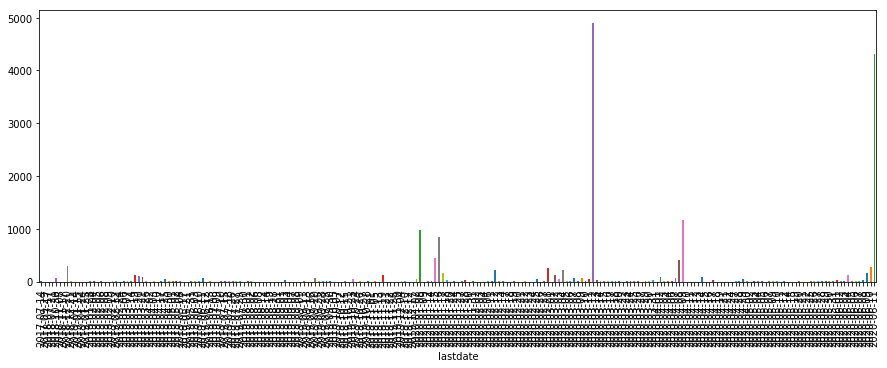

In [38]:
grouped_results = influxdf.groupby(["lastdate"]).count()["time_last"]
print(grouped_results.head())

grouped_results.plot.bar()

plt.show()

firstdate
2017-05-27    1
2017-07-14    5
2017-09-29    3
2018-07-17    3
2018-07-21    3
Name: time_first, dtype: int64


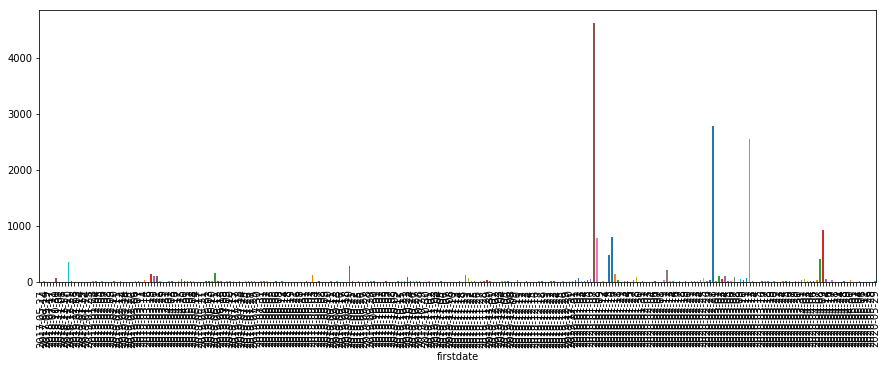

In [37]:
#And again but with firstdate

grouped_results = influxdf.groupby(["firstdate"]).count()["time_first"]
print(grouped_results.head())

grouped_results.plot.bar()

plt.show()

That's way too many spikes for us to be able to pick a specific day and say this is the start of our "stable" data. Also, it is more important that we know when sensor tags in influxDB started matching the current equivalent tags in SkySpark.


The best way to visualize this will be to filter to only the records that are **not** able to join with a 2020-06-05 export of "metadata" from SkySpark - whatever the latest date is for those records is the start of our date range for "stable" data.

### Join the SkySpark metadata with the influxDB-queried data

(goal is to create a dataframe of all entries NOT in the intersection)

In [22]:
#Prep the SkySpark metadata dataframe by only keeping the first entry of each 
#   of duplicates in the 185 conflicting entries

metadata_nodup = metadata.drop_duplicates(subset=['uniqueId'], keep='first')

print("metadata with duplicates =", len(metadata))
print("metadata without duplicates =", len(metadata_nodup))
print("difference:",len(metadata)-len(metadata_nodup))

metadata_nodup.set_index("uniqueId", inplace=True)

metadata with duplicates = 7938
metadata without duplicates = 7832
difference: 106


In [32]:
#print(influxdf.index[5])
#print(metadata_nodup.index[5])
#influxdf.index.difference(metadata_nodup.index)
#metadata_nodup.index.difference(influxdf.index)

In [17]:


#What units are present in influxdf?
print("Units present in skySpark:",metadata_nodup['unit'].unique(),"\n\n")
print("Units present in influxDB:",influxdf['unit'].unique())

Units present in skySpark: ['kWh' 'A' '°C' nan 'ppm' '%' 'kW' 'W' 'L/s' 'L' 'Hz' 'Pa' 'kPa' '_' 'V'
 '%RH' 'psi' '°F' 'min' 'ft/min' 'm³' 'rpm' 'bar' 'ft' 'm³/h'] 


Units present in influxDB: ['%' '_' '°C' 'kPa' 'omit' 'Pa' '%RH' 'L/s' 'Hz' 'kWh' 'kW' 'ppm' 'ft/min'
 'm³' 'A' 'min' 'W' 'V' 'psi' '°F' 'rpm' 'L']


In [14]:
#DF of intersection of metadata and influxdb data (has to exist in both):

test = pd.merge(left=influxdf, right=metadata_nodup, how="inner", left_index=True, right_index=True)

firstdate
2017-07-14     1
2017-09-29     1
2018-07-17     1
2018-07-21     1
2018-10-30    23
              ..
2020-05-06     2
2020-05-11     1
2020-05-26     2
2020-05-28     1
2020-05-29     4
Name: time_first, Length: 232, dtype: int64


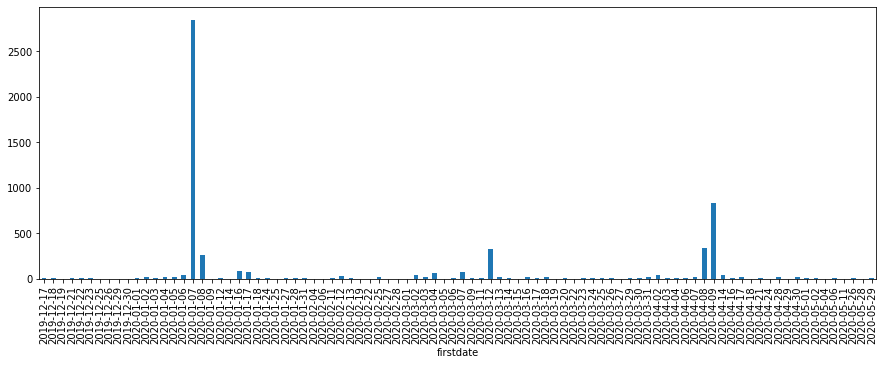

In [15]:
grouped_results = test.groupby(["firstdate"]).count()['time_first']
print(grouped_results)
grouped_results.tail(90).plot.bar()
plt.show()

There is more that could be looked at but one simple conclusion is that over 2500 sensors don't have any records from before 2020-01-07. That makes this a reasonable minimum date (i.e. start date). As for the end date, there is no obvious last date. Using the code below we can try to identify days with no data but that isn't critical. 

### Recommendation: 2020-01-08 to 2020-06-01 (inclusive)

In [23]:
query4 = '''select count(value) from UBC_EWS 
where siteRef=$siteRef and time > now() - 45d group By time(1d)'''

result4 = client.query(query = query4, bind_params=where_params, chunked=True, chunk_size=10000)

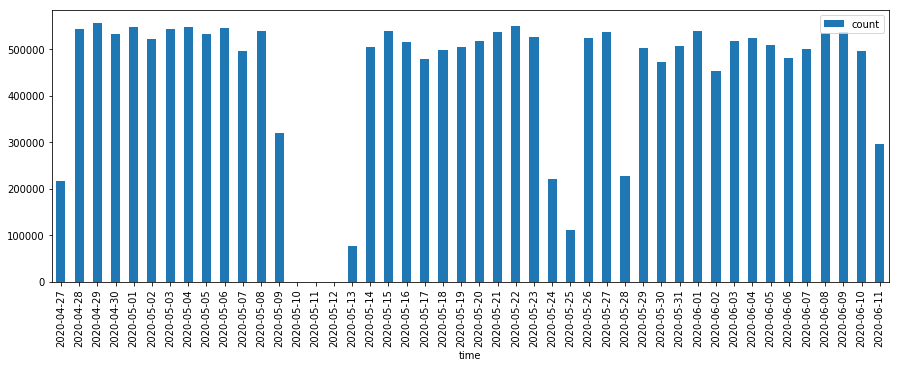

In [36]:
list_of_df=[]
n=0

for item in result4.get_points(measurement="UBC_EWS"):
    list_of_df.append(pd.DataFrame.from_dict(item,orient="index"))

perday = pd.concat(list_of_df, axis=1)
perday = perday.transpose(copy=True)
perday.reset_index(drop=True, inplace=True)
list_of_df=None
perday['time'] = pd.to_datetime(firstdf['time']).dt.date
perday.set_index('time', inplace=True)
perday.plot.bar()

plt.show()